In [12]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
import random
from collections import Counter

# Additional imports for later metrics
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    precision_score,
    recall_score
)

In [13]:
df = pd.read_table('/content/complete_score_Mprops_1_2_smoothed_sasa_v2.txt')

#to filter to just one allele
df = df[df['allele'] == 'HLA-A*02:01']
df

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,peptide,allele,immunogenicity,aliphathic_index,boman,charge,hphobic,...,Foreignness_Score,Dissimilarity_Score,quant_foreign,smoothed_foreign,master_property_score,Mprop1,Mprop2,combo,sasa_af,smoothed_af_sasa
3,3,3,3,KLFESKAEL,HLA-A*02:01,0,97.777778,1.498889,-0.021908,0.348054,...,0.00000,1.465494e-14,-5.199338,-4.832563,0.346405,0.266938,0.396085,KLFESKAELHLA-A*02:01,7.051576,5.552952
4,4,4,4,KLFESKAELA,HLA-A*02:01,0,98.000000,1.168000,-0.021908,0.372761,...,0.00000,0.000000e+00,-5.199338,-4.639388,0.363109,0.271797,0.418384,KLFESKAELAHLA-A*02:01,7.206483,5.537300
7,7,7,7,GIPENSFNV,HLA-A*02:01,0,75.555556,1.178889,-1.022848,0.274185,...,0.99238,0.000000e+00,1.067571,-3.991097,0.284099,0.256121,0.303310,GIPENSFNVHLA-A*02:01,4.150414,5.468257
9,9,9,9,TTLFHTFYEL,HLA-A*02:01,0,78.000000,0.352000,-0.783389,0.422806,...,0.00000,0.000000e+00,-5.199338,-3.692507,0.413127,0.357311,0.431932,TTLFHTFYELHLA-A*02:01,8.864129,5.407521
15,15,15,15,VLSSLVLVPL,HLA-A*02:01,0,243.000000,-2.500000,-0.024105,0.152269,...,0.00000,2.930989e-14,-5.199338,-3.540915,0.405513,0.510486,0.306391,VLSSLVLVPLHLA-A*02:01,4.727356,5.271351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24512,24512,24512,24513,SSADVEFCL,HLA-A*02:01,1,86.666667,0.811111,-2.052708,0.058674,...,0.00000,0.000000e+00,-5.199338,-1.473908,0.297553,0.344981,0.290538,SSADVEFCLHLA-A*02:01,5.831448,6.434407
24513,24513,24513,24514,VMIIVSSLAV,HLA-A*02:01,1,214.000000,-2.424000,-0.024105,0.144207,...,0.00000,8.689509e-10,-5.199338,-0.432872,0.417672,0.541353,0.340815,VMIIVSSLAVHLA-A*02:01,8.057390,6.492722
24530,24530,24530,24531,TLLYVLFEV,HLA-A*02:01,1,194.444444,-1.811111,-1.023642,0.338318,...,1.00000,1.664470e-01,5.199338,1.406596,0.440149,0.574564,0.318688,TLLYVLFEVHLA-A*02:01,5.831448,5.390313
24533,24533,24533,24534,ILHTNMPNV,HLA-A*02:01,1,118.888889,0.475556,0.216148,0.262777,...,0.00000,5.118128e-14,-5.199338,0.500110,0.413766,0.433962,0.372206,ILHTNMPNVHLA-A*02:01,5.418434,5.212084


In [14]:
len(df[df['immunogenicity'] == 1])

2524

In [15]:
len(df[df['immunogenicity'] == 0])

2598

In [16]:
# 2. DEFINE AMINO ACID ALPHABET
# ---------------------------------
# Here, we define a typical set of 20 amino acids.
# (You might adjust to include rare amino acids if needed.)
amino_acids = "ACDEFGHIKLMNPQRSTVWY"
aa_to_idx = {aa: idx for idx, aa in enumerate(amino_acids)}

# -----------------------------------
# 3. ONE-HOT ENCODING FUNCTION
# -----------------------------------
def one_hot_encode(peptide, aa_to_idx):
    """
    Convert a peptide sequence into a one-hot encoded tensor.

    Args:
        peptide (str): The peptide sequence (e.g. "ACD...").
        aa_to_idx (dict): A mapping from amino acid character to index (0..19).

    Returns:
        torch.FloatTensor: Shape = (length_of_peptide, 20).
    """
    # Create a 2D array of zeros: shape (len(peptide), 20)
    encoding = np.zeros((len(peptide), len(aa_to_idx)), dtype=np.float32)

    # Fill in 1 at the position corresponding to each amino acid
    for i, aa in enumerate(peptide):
        if aa in aa_to_idx:
            encoding[i, aa_to_idx[aa]] = 1.0
        else:
            # If an amino acid is unknown, you could handle it here
            # e.g., ignore or use a special "unknown" index
            pass

    return torch.tensor(encoding)

In [17]:
# ---------------------------------------------------------
# 4. CUSTOM DATASET FOR PEPTIDE + IMMUNOGENICITY
# ---------------------------------------------------------
class PeptideDataset(Dataset):
    def __init__(self, dataframe):
        """
        Args:
            dataframe (pd.DataFrame): Must have 'peptide' and 'immunogenicity' columns.
        """
        self.dataframe = dataframe.reset_index(drop=True)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        """
        Returns a tuple: (one_hot_encoded_sequence, label)
        where one_hot_encoded_sequence is a FloatTensor of shape (peptide_length, 20)
        and label is an integer (0 or 1).
        """
        row = self.dataframe.iloc[idx]
        peptide_str = row['peptide']
        label = row['immunogenicity']

        # One-hot encode the peptide
        encoded_seq = one_hot_encode(peptide_str, aa_to_idx)

        # Convert label to a torch LongTensor
        label = torch.tensor(label, dtype=torch.long)

        return encoded_seq, label

In [18]:
def collate_fn(batch):
    """
    `batch` is a list of (encoded_seq, label) pairs.
    We need to:
      1) Pad the variable-length sequences in the batch
      2) Stack them into a single tensor
      3) Stack labels into a single tensor
    """
    sequences = [item[0] for item in batch]
    labels = [item[1] for item in batch]

    # Pad sequences to the maximum length in this batch
    # Resulting shape: (batch_size, max_seq_len, 20)
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0.0)

    # Convert labels list into a tensor
    labels = torch.stack(labels)

    return padded_sequences, labels

In [19]:
# ------------------------------------------------
# 6. SPLIT DATA INTO TRAIN & VALIDATION
# ------------------------------------------------
# Here, we do a simple 75/25 split. You can adjust as needed.
indices = list(range(len(df)))
random.shuffle(indices)
split_idx = int(0.75 * len(df))
train_indices = indices[:split_idx]
val_indices = indices[split_idx:]

train_df = df.iloc[train_indices].reset_index(drop=True)
val_df = df.iloc[val_indices].reset_index(drop=True)

train_dataset = PeptideDataset(train_df)
val_dataset = PeptideDataset(val_df)

# Create DataLoaders
batch_size = 24
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                        collate_fn=collate_fn)

### Time to implement an RNN:

![image.png](https://github.com/david-zhang03/rnn-lstm-tutorial/blob/main/rnn.png?raw=true)

Recall: each layer of the RNN can be parameterized as

$$h_t = tanh(x_t W_{ih}^T + b_{ih} + h_{t-1}W_{hh}^T + b_{hh})$$

In [ ]:
# --------------------------------------------
# 7. DEFINE A SIMPLE RNN MODEL
# --------------------------------------------
class SimpleRNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        """
        A simple RNN-based model for binary classification.

        Args:
            input_size (int): The size of each one-hot vector (e.g. 20).
            hidden_size (int): Number of features in the RNN hidden state.
            num_layers (int): Number of stacked RNN layers.
            num_classes (int): Output dimension (2 for binary classification).
        """
        super(SimpleRNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # We can use nn.RNN, nn.LSTM, or nn.GRU. Here, let's use a basic RNN.
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )

        # Final classification layer
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        """
        x: shape (batch_size, seq_length, input_size)
        """
        # Initialize hidden state for RNN
        # shape: (num_layers, batch_size, hidden_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)

        # Forward pass through RNN
        # out shape: (batch_size, seq_length, hidden_size)
        # hn shape: (num_layers, batch_size, hidden_size)
        out, hn = self.rnn(x, h0)

        # We can use the last time-step's output for classification
        # out[:, -1, :] is the final hidden state of the last time step
        out = out[:, -1, :]  # shape: (batch_size, hidden_size)

        # Pass through fully connected layer
        out = self.fc(out)  # shape: (batch_size, num_classes)
        return out


    def forward(self, x):
      # Initialize hidden state on the same device as x
      h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=x.device)
      out, hn = self.rnn(x, h0)
      out = out[:, -1, :]  # Use the last time-step output
      out = self.fc(out)
      return out

In [ ]:
input_size = 20
hidden_size = 30
num_layers = 10
num_classes = 2 # binary classification

In [ ]:
# Set device: use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Instantiate the model and move it to device
model = SimpleRNNModel(input_size, hidden_size, num_layers, num_classes).to(device)

# Example for CrossEntropyLoss with weights (imbalanced dataset):
# Suppose you have 19k negatives and 5k positives.
total_samples = len(df)
weight_for_negative = total_samples / len(df[df['immunogenicity'] == 0])
weight_for_positive = total_samples / len(df[df['immunogenicity'] == 1])
weights = torch.tensor([weight_for_negative, weight_for_positive]).to(device)

#use for imbalanced data
#criterion = nn.CrossEntropyLoss(weight=weights)

#use for non-imblance
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# -------------------------------------
# 9. TRAINING LOOP
# -------------------------------------
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for batch_sequences, batch_labels in train_loader:
        # Move batch data to GPU
        batch_sequences = batch_sequences.to(device)
        batch_labels = batch_labels.to(device)

        outputs = model(batch_sequences)  # (batch_size, num_classes)
        loss = criterion(outputs, batch_labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)

    # ----------------------------
    # 10. VALIDATION / EVALUATION
    # ----------------------------
    model.eval()
    val_loss = 0.0

    # We'll store predictions and labels for metrics
    all_labels = []
    all_preds = []
    all_probs = []  # store probability of the positive class

    with torch.no_grad():
        for val_sequences, val_labels in val_loader:
            # Move validation data to GPU
            val_sequences = val_sequences.to(device)
            val_labels = val_labels.to(device)

            val_outputs = model(val_sequences)
            loss = criterion(val_outputs, val_labels)
            val_loss += loss.item()

            # Convert outputs to probabilities using softmax
            val_probs = torch.softmax(val_outputs, dim=1)

            # Predicted labels (0 or 1)
            _, predicted = torch.max(val_probs, dim=1)

            # Save labels, predicted labels, and positive-class probabilities
            all_labels.extend(val_labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(val_probs[:, 1].cpu().numpy())  # probability of class '1'

    avg_val_loss = val_loss / len(val_loader)

    # Compute metrics
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)

    try:
        auc_roc = roc_auc_score(all_labels, all_probs)
    except ValueError:
        auc_roc = 0.0

    try:
        pr_auc = average_precision_score(all_labels, all_probs)
    except ValueError:
        pr_auc = 0.0

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Train Loss: {avg_loss:.4f}")
    print(f"  Val Loss:   {avg_val_loss:.4f}")
    print(f"  Accuracy:   {accuracy*100:.2f}%")
    print(f"  Precision:  {precision:.4f}")
    print(f"  Recall:     {recall:.4f}")
    print(f"  AUC-ROC:    {auc_roc:.4f}")
    print(f"  PR AUC:     {pr_auc:.4f}")
    print("-"*50)

Using device: cuda
Epoch [1/50]
  Train Loss: 0.6946
  Val Loss:   0.6953
  Accuracy:   48.79%
  Precision:  0.0000
  Recall:     0.0000
  AUC-ROC:    0.5386
  PR AUC:     0.5604
--------------------------------------------------
Epoch [2/50]
  Train Loss: 0.6934
  Val Loss:   0.6942
  Accuracy:   48.79%
  Precision:  0.0000
  Recall:     0.0000
  AUC-ROC:    0.5309
  PR AUC:     0.5552
--------------------------------------------------
Epoch [3/50]
  Train Loss: 0.6915
  Val Loss:   0.6918
  Accuracy:   51.76%
  Precision:  0.5271
  Recall:     0.5625
  AUC-ROC:    0.5206
  PR AUC:     0.5452
--------------------------------------------------
Epoch [4/50]
  Train Loss: 0.6843
  Val Loss:   0.6904
  Accuracy:   52.07%
  Precision:  0.5392
  Recall:     0.4405
  AUC-ROC:    0.5413
  PR AUC:     0.5636
--------------------------------------------------
Epoch [5/50]
  Train Loss: 0.6811
  Val Loss:   0.6919
  Accuracy:   52.85%
  Precision:  0.5353
  Recall:     0.6006
  AUC-ROC:    0.552

KeyboardInterrupt: 

### Time to implement an LSTM

![image.png](https://github.com/david-zhang03/rnn-lstm-tutorial/blob/main/lstm.png?raw=true)

### A few things to note:

1. **Cell state ($C_t$):**  
   Notice the horizontal line towards the top of each module—this is referred to as the **cell state** or $C_t$.  
   You can think of it as a running, compressed state of information from all previous time steps $t' < t$.

2. **Gating mechanisms:**  
   One of the notable architectural improvements of an LSTM compared to a vanilla RNN is its ability to **regulate what information flows into the cell state** using several gates.

---

### Inner-workings of an LSTM and its gating mechanisms

#### 1. Forget Gate ($f_t$)
Used to determine what part of the cell state should be discarded.

- **Input:**  
  $x_t$ (input at time $t$), $h_{t-1}$ (hidden state from previous time step)

- **Output:**  
  $f_t \in [0, 1]^d$ (forget vector, element-wise multiplied with $C_{t-1}$)

- **Parameterization:**  
  $f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)$

---

#### 2. Input Gate ($i_t$)
Controls what new information gets stored in the cell state.

- **Input:**  
  $x_t$, $h_{t-1}$

- **Output:**  
  $i_t \in [0, 1]^d$

- **Parameterization:**  
  $i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)$

---

#### 3. Candidate Values ($\tilde{C}_t$)
New candidate values to be added to the cell state.

- **Parameterization:**  
  $\tilde{C}_t = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C)$

---

### 4. Update step

Taking the output of our forget gate $f_t$ and our candidate values from our current timestep, we update $C_{t-1}$

- **Update:**
  $C_{t} = f_t \cdot C_{t-1} + i_t \cdot \tilde{C}_t$

---

#### 5. Output Gate ($o_t$)
Finally, we output our hidden state $h_t$ which will be passed on to succeeding modules. $h_t$ is a filtered version of our updated cell state $C_t$.

- **Parameterization:**  
  $o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)$

- **Final hidden state:**  
  $h_t = o_t \odot \tanh(C_t)$


In [28]:
class SimpleLSTMModel(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, num_classes):
    """
    A simple LSTM-based model for binary classification.

    Args:
        input_size (int): The size of each one-hot vector (e.g., 20 for amino acids).
        hidden_size (int): Number of features in the LSTM hidden state.
        num_layers (int): Number of stacked LSTM layers.
        num_classes (int): Output dimension (e.g., 2 for binary classification).
    """
    super(SimpleLSTMModel, self).__init__()
    self.hidden_size=hidden_size
    self.num_layers=num_layers

    self.lstm = nn.LSTM(
        input_size=input_size,
        hidden_size=hidden_size,
        num_layers=num_layers,
        batch_first=True # (batch, seq, feature_dim)
    )

    self.fc = nn.Linear(hidden_size, num_classes)

  def forward(self, x):
    """
    x.shape = [batch_size, seq_len, input_dims]
    """

    # Remember: each LSTM module takes in the previous timestep's hidden state,
    # the "running" candidate state, as well as the input sequence

    # initialize inputs as zero vectors
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=x.device)
    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=x.device)

    # lstm(input, (hidden, candidate))
    out, (hn, cn) = self.lstm(x, (h0, c0)) # out has dims (batch_size, seq_len, hidden_dim)

    out = out[:, -1, :] # (batch_size, hidden_dim)

    # project for binary classification
    out = self.fc(out)
    return out

Note that the torch.nn.LSTM module we initialize is exactly what we just went over and can be found [here](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)

![image.png](https://github.com/david-zhang03/rnn-lstm-tutorial/blob/main/pytorch-lstm-docs.png?raw=true)

$g_t$ here is used to represent your intermediate candidate state $\tilde{C}_t$

Here are our train and val loops

In [21]:
input_size = 20
hidden_size = 30
num_layers = 10
num_classes = 2 # binary classification

In [29]:
# Set device: use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Instantiate the model and move it to device
model = SimpleLSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)

# Example for CrossEntropyLoss with weights (imbalanced dataset):
# Suppose you have 19k negatives and 5k positives.
total_samples = len(df)
weight_for_negative = total_samples / len(df[df['immunogenicity'] == 0])
weight_for_positive = total_samples / len(df[df['immunogenicity'] == 1])
weights = torch.tensor([weight_for_negative, weight_for_positive]).to(device)

criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(model.parameters(), lr=0.0001)


# metrics to track and plot
train_losses = []
val_losses = []
accuracies = []
precisions = []

# -------------------------------------
# 9. TRAINING LOOP
# -------------------------------------
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for batch_sequences, batch_labels in train_loader:
        # Move batch data to GPU
        batch_sequences = batch_sequences.to(device)
        batch_labels = batch_labels.to(device)

        outputs = model(batch_sequences)  # (batch_size, seq_len, input_size)
        loss = criterion(outputs, batch_labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)

    # ----------------------------
    # 10. VALIDATION / EVALUATION
    # ----------------------------
    model.eval()
    val_loss = 0.0

    # We'll store predictions and labels for metrics
    all_labels = []
    all_preds = []
    all_probs = []  # store probability of the positive class

    with torch.no_grad():
        for val_sequences, val_labels in val_loader:
            # Move validation data to GPU
            val_sequences = val_sequences.to(device)
            val_labels = val_labels.to(device)

            val_outputs = model(val_sequences)
            loss = criterion(val_outputs, val_labels)
            val_loss += loss.item()

            # Convert outputs to probabilities using softmax
            val_probs = torch.softmax(val_outputs, dim=1)

            # Predicted labels (0 or 1)
            _, predicted = torch.max(val_probs, dim=1)

            # Save labels, predicted labels, and positive-class probabilities
            all_labels.extend(val_labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(val_probs[:, 1].cpu().numpy())  # probability of class '1'

    avg_val_loss = val_loss / len(val_loader)

    # Compute metrics
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)

    try:
        auc_roc = roc_auc_score(all_labels, all_probs)
    except ValueError:
        auc_roc = 0.0

    try:
        pr_auc = average_precision_score(all_labels, all_probs)
    except ValueError:
        pr_auc = 0.0

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"  Train Loss: {avg_loss:.4f}")
    print(f"  Val Loss:   {avg_val_loss:.4f}")
    print(f"  Accuracy:   {accuracy*100:.2f}%")
    print(f"  Precision:  {precision:.4f}")
    print(f"  Recall:     {recall:.4f}")
    print(f"  AUC-ROC:    {auc_roc:.4f}")
    print(f"  PR AUC:     {pr_auc:.4f}")
    print("-"*50)

    train_losses.append(avg_loss)
    val_losses.append(avg_val_loss)
    accuracies.append(accuracy)
    precisions.append(precision)

Using device: cuda
Epoch [1/50]
  Train Loss: 0.6945
  Val Loss:   0.6942
  Accuracy:   48.56%
  Precision:  0.4856
  Recall:     1.0000
  AUC-ROC:    0.5328
  PR AUC:     0.5038
--------------------------------------------------
Epoch [2/50]
  Train Loss: 0.6934
  Val Loss:   0.6933
  Accuracy:   48.56%
  Precision:  0.4856
  Recall:     1.0000
  AUC-ROC:    0.5427
  PR AUC:     0.5142
--------------------------------------------------
Epoch [3/50]
  Train Loss: 0.6932
  Val Loss:   0.6933
  Accuracy:   48.56%
  Precision:  0.4856
  Recall:     1.0000
  AUC-ROC:    0.5539
  PR AUC:     0.5180
--------------------------------------------------
Epoch [4/50]
  Train Loss: 0.6933
  Val Loss:   0.6933
  Accuracy:   48.56%
  Precision:  0.4856
  Recall:     1.0000
  AUC-ROC:    0.5518
  PR AUC:     0.5153
--------------------------------------------------
Epoch [5/50]
  Train Loss: 0.6932
  Val Loss:   0.6932
  Accuracy:   48.56%
  Precision:  0.4856
  Recall:     1.0000
  AUC-ROC:    0.557

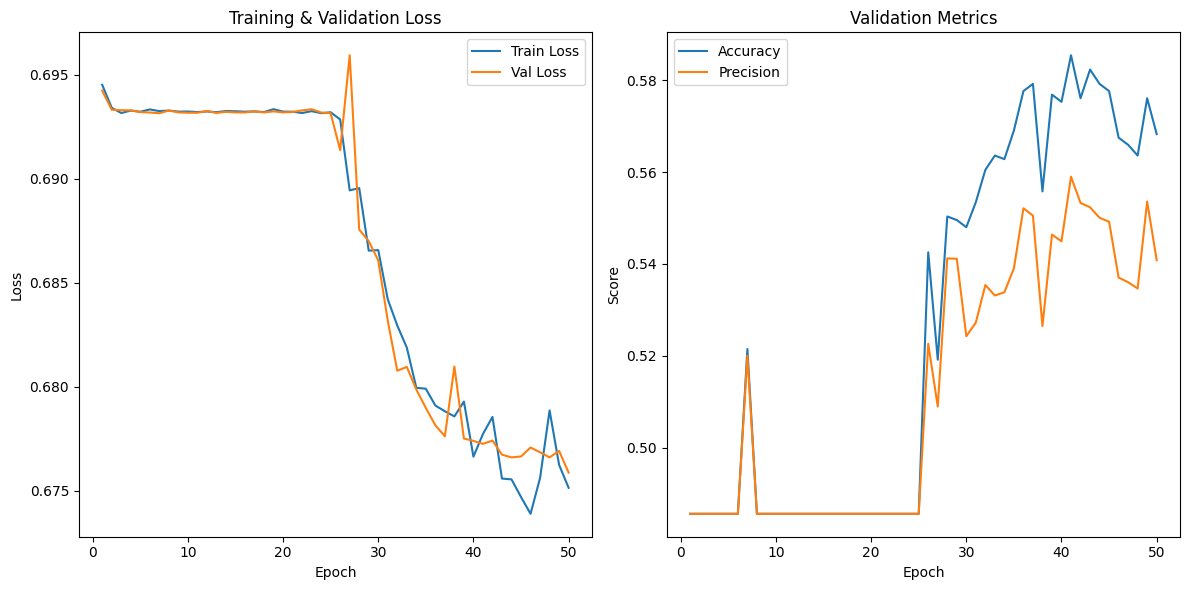

In [31]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies, label="Accuracy")
plt.plot(epochs, precisions, label="Precision")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Validation Metrics")
plt.legend()

plt.tight_layout()
plt.show()